## Covid19 Analysis & Forecast
##### by Khairul Omar

### 1. Import data

In [483]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 50
import numpy as np
import json
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [252]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [253]:
# One-day download from John Hopkins Hospital database
date  = pd.to_datetime(f'20200317', format='%Y%m%d')
day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
df = pd.read_csv(url)
df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [351]:
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
#df['update_date'] = df.updated.apply(lambda row: pd.to_datetime(f'{str(row)[0:4]}{str(row)[5:7]}{str(row)[8:10]}', format='%Y%m%d'))

df0 = df.copy() # temp

In [443]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands', 'French Polynesia', 'Saint Barthelemy', 'St Martin']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'DC'
        if state == "Virgin Islands, U.S.":
            s = 'VI'
        elif state.find(', ') > 0:
            s = state[state.find(', ')+2:state.find(', ')+4]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'      
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int((dfstate.iloc[i-1].confirmed_raw
                                                                         + dfstate.iloc[i+1].confirmed_raw)/2)
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']
df = df[allcols]
df = df.reset_index(drop=True)

In [397]:
# country = 'France'
# data = df[df.state==country][:15]
# display(data)
# for col in [data.updated, data.date]:
#     fig, ax = plt.subplots()
#     plt.plot(col, data.new_confirmed)
#     ax.set_title(col.name)
#     plt.show()

In [529]:
# Country-level data
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1.shape
df1 = df1.sort_values(['date','confirmed'], ascending=False)
df1 = df1[['date','country'] + allcols[-6:]]
df1 = df1.set_index('date')

### 2. Analyse latest data

In [566]:

countries

['China',
 'Italy',
 'Iran',
 'Spain',
 'Germany',
 'South Korea',
 'France',
 'United States',
 'Switzerland',
 'United Kingdom',
 'Netherlands',
 'Norway',
 'Austria',
 'Belgium',
 'Sweden',
 'Denmark',
 'Japan',
 'Malaysia',
 'Canada',
 'Australia',
 'Portugal']


Top 20 countries by total cases as of 17/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-17,China,81058,3230,68798,32,13,888
2020-03-17,Italy,31506,2503,2941,3526,345,192
2020-03-17,Iran,16169,988,5389,1116,135,799
2020-03-17,Spain,11748,533,1028,1806,191,498
2020-03-17,Germany,9257,24,67,1985,7,0
2020-03-17,South Korea,8320,81,1407,79,6,270
2020-03-17,France,7681,148,12,1023,0,0
2020-03-17,United States,6421,108,17,1732,23,0
2020-03-17,Switzerland,2700,27,4,250,13,0



New confirmed cases from 1/2/2020 to 17/3/2020


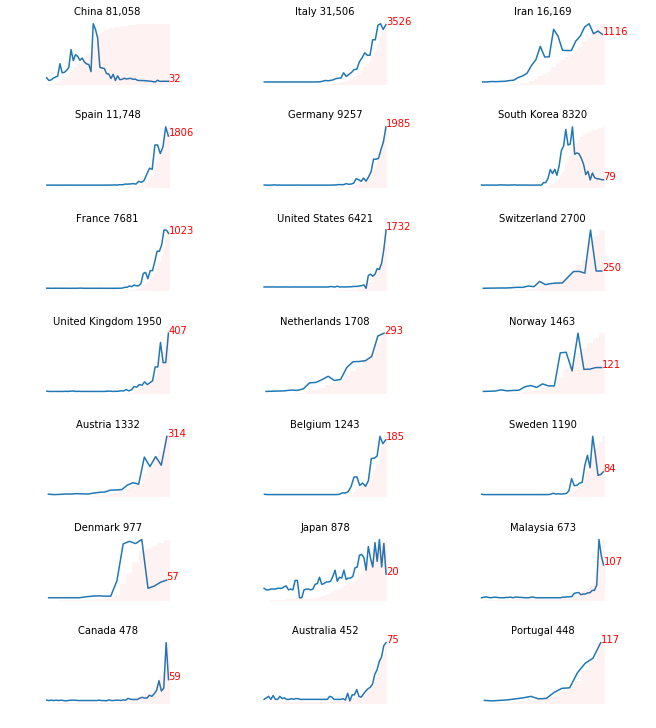

In [569]:
# Display one day data
day   = 17
month = 3
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

latest = df1.loc[date]
print(f'\nTop 20 countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:22])

# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:22].country)
countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=3, nrows=round(len(countries)/3), figsize=(9,10), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until, cdata.loc[until].new_confirmed, cdata.loc[until].new_confirmed, color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    clabel = f'{str(cdata.loc[until].confirmed)[:2]},{str(cdata.loc[until].confirmed)[2:]}' if cdata.loc[until].confirmed > 9999 else cdata.loc[until].confirmed
    ax.set_title(f'{countries[i]} {clabel}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.savefig('top20.png')
plt.show()

### 3. ARIMA time series forecasting

Validate stationarity from time shifts
Shift d=1: adfuller:0.019, mean:1.8
Shift d=2: adfuller:0.008, mean:0.4
Shift d=3: adfuller:0.306, mean:-0.1
Shift d=4: adfuller:0.0, mean:-0.8


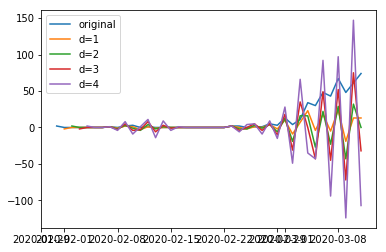

In [552]:
# Select starting date for model input
end_act = pd.to_datetime('20200311', format='%Y%m%d')
dfuk0 = df1[df1.country=='United Kingdom'].new_confirmed.sort_index()
dfuk = dfuk0[:end_act]

# Shift data
dfuk1  = dfuk - dfuk.shift(1)
dfuk2  = dfuk1 - dfuk1.shift(1)
dfuk3  = dfuk2 - dfuk2.shift(1)
dfuk4  = dfuk3 - dfuk3.shift(1)
print(f'Validate stationarity from time shifts')
print(f'Shift d=1: adfuller:{round(adfuller(dfuk1[1:])[1],3)}, mean:{round(np.nanmean(dfuk1),1)}')
print(f'Shift d=2: adfuller:{round(adfuller(dfuk2[2:])[1],3)}, mean:{round(np.nanmean(dfuk2),1)}')
print(f'Shift d=3: adfuller:{round(adfuller(dfuk3[3:])[1],3)}, mean:{round(np.nanmean(dfuk3),1)}')
print(f'Shift d=4: adfuller:{round(adfuller(dfuk4[4:])[1],3)}, mean:{round(np.nanmean(dfuk4),1)}')

plt.plot(dfuk, label='original')
plt.plot(dfuk1, label='d=1')
plt.plot(dfuk2, label='d=2')
plt.plot(dfuk3, label='d=3')
plt.plot(dfuk4, label='d=4')
plt.legend()
plt.show()

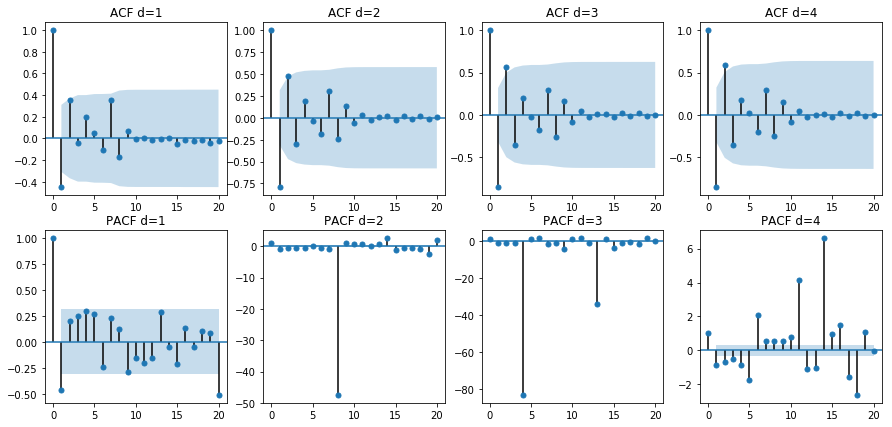

In [553]:
# Check ACF & PCF
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15,7))
plot_acf(dfuk1[1:], lags=20, ax=axes.flat[0], title='ACF d=1')
plot_acf(dfuk2[2:], lags=20, ax=axes.flat[1], title='ACF d=2')
plot_acf(dfuk3[3:], lags=20, ax=axes.flat[2], title='ACF d=3')
plot_acf(dfuk4[4:], lags=20, ax=axes.flat[3], title='ACF d=4')
plot_pacf(dfuk1[1:], lags=20, ax=axes.flat[4], title='PACF d=1')
plot_pacf(dfuk2[2:], lags=20, ax=axes.flat[5], title='PACF d=2')
plot_pacf(dfuk3[3:], lags=20, ax=axes.flat[6], title='PACF d=3')
plot_pacf(dfuk4[4:], lags=20, ax=axes.flat[7], title='PACF d=4');

In [554]:
# Run model
p, d, q = 1, 2, 1
sarima = SARIMAX(dfuk, order=(p, d, q),
                enforce_stationarity=False).fit()
# print(sarima.summary())
# sarima.plot_diagnostics(figsize=(12,7));

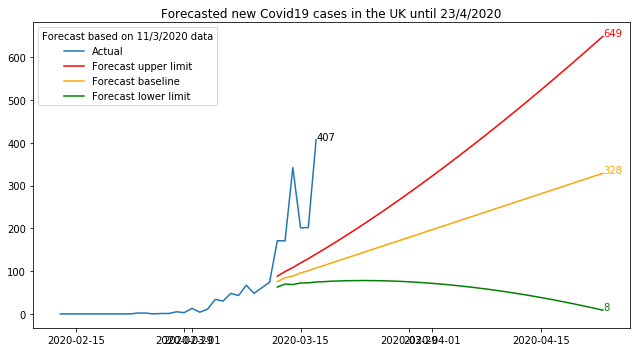

In [556]:
# Set plotting periods
test_start = dfuk.index.max() + oneday
test_end   = test_start + oneday * 7*6
act_start  = test_start - oneday * 7*4
pred = sarima.predict(start=test_start, end=test_end, dynamic=True)
pred_conf = sarima.get_forecast(len(pred)).conf_int()
upper = pred_conf.iloc[:,1]
lower = pred_conf.iloc[:,0].clip(0)

# Plot data
fig, ax = plt.subplots(figsize=(9,5))
plt.plot(dfuk0[act_start:], label='Actual')

# # Rolling mean
# n = 3 # days
# rolling_mean = dfuk0[act_start:].rolling(window=n).mean()
# plt.plot(rolling_mean, label=f'Actual: {n}-day rolling mean')

plt.plot(upper, label='Forecast upper limit', c='red')
plt.plot(pred, label='Forecast baseline', c='orange')
plt.plot(lower, label='Forecast lower limit', c='green')

plt.text(dfuk0.index.max(), dfuk0[-1], dfuk0[-1])
plt.text(test_end, int(upper.iloc[-1]), int(upper.iloc[-1]), color='red')
plt.text(test_end, int(pred.iloc[-1]), int(pred.iloc[-1]), color='orange')
plt.text(test_end, int(lower.iloc[-1]), int(lower.iloc[-1]), color='green')

plt.legend(loc='upper left', title=f'Forecast based on {end_act.day}/{end_act.month}/2020 data')
ax.set_title(f'Forecasted new Covid19 cases in the UK until {test_end.day}/{test_end.month}/2020')
plt.tight_layout()
plt.savefig('forecast_uk.png', pad_inches=0)
plt.show()